References:

- https://github.com/chuachinhon/practical_nlp/blob/master/notebooks/1.0_speech_sentiment_cch.ipynb
- https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664

In [1]:
import nltk
from nltk.corpus import PlaintextCorpusReader
import matplotlib as mpl
import pandas as pd
import numpy as np
import re
from transformers import pipeline
import os
import matplotlib.pyplot as plt

In [2]:
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [3]:
entries = os.scandir('..\\Dataset\\')
fids = []
for entry in entries:
    if 'eng' in entry.name:
        fids.append(entry.name)
        
print(fids)

['1992_eng.txt', '2002_eng.txt', '2004_eng.txt', '2005_eng.txt', '2006_eng.txt', '2007_eng.txt', '2008_eng.txt', '2009_eng.txt', '2010_eng.txt', '2011_eng.txt', '2012_eng.txt', '2013_eng.txt', '2014_eng.txt', '2015_eng.txt', '2016_eng.txt', '2017_eng.txt', '2018_eng.txt', '2019_eng.txt', '2021_eng.txt', '2022_eng.txt']


In [4]:
# Define the file directory
file_directory = '..\\Dataset\\'

df  = pd.DataFrame([['start','start']],columns=['Paragraphs','Year'])

for i in range(len(fids)): 
    with open(file_directory + fids[i], 'r', encoding="utf8") as file_to_read:
        temp_df = file_to_read.read()
        temp_df = (pd.DataFrame(temp_df.split("\n\n"))).rename(columns={0: "Paragraphs"})
        temp_df['Year'] = fids[i] 
    df = pd.concat([df,temp_df])

#Create new column to store Paragraph Numbers 
df['ParasNo'] = df.index

In [5]:
#Reset Index and drop dummy row
df.reset_index(inplace=True, drop=True)
df.drop(index=0, inplace=True)
df.reset_index(inplace=True, drop=True)

#Rearranging columns
df = df[['Year','ParasNo','Paragraphs']] 
df

Year  ParasNo                                         Paragraphs
0     1992_eng.txt        0  In 1984, the government presented Vision 1999,...
1     1992_eng.txt        1  How have we done? What policies must we pursue...
2     1992_eng.txt        2  Chart 1 shows how we have done so far. In 1984...
3     1992_eng.txt        3  Our quality of life has improved. We have bett...
4     1992_eng.txt        4  But I am particularly satisfied over 2 areas. ...
...            ...      ...                                                ...
2346  2022_eng.txt      100  Thankfully, for 57 years, over three generatio...
2347  2022_eng.txt      101  Never take this trust, nor this competence, fo...
2348  2022_eng.txt      102  Leadership succession is therefore of paramoun...
2349  2022_eng.txt      103  The next few decades will be bracing but exhil...
2350  2022_eng.txt      104                          Thank you and good night!

[2351 rows x 3 columns]

In [6]:
df.set_index('Year')

ParasNo                                         Paragraphs
Year                                                                    
1992_eng.txt        0  In 1984, the government presented Vision 1999,...
1992_eng.txt        1  How have we done? What policies must we pursue...
1992_eng.txt        2  Chart 1 shows how we have done so far. In 1984...
1992_eng.txt        3  Our quality of life has improved. We have bett...
1992_eng.txt        4  But I am particularly satisfied over 2 areas. ...
...               ...                                                ...
2022_eng.txt      100  Thankfully, for 57 years, over three generatio...
2022_eng.txt      101  Never take this trust, nor this competence, fo...
2022_eng.txt      102  Leadership succession is therefore of paramoun...
2022_eng.txt      103  The next few decades will be bracing but exhil...
2022_eng.txt      104                          Thank you and good night!

[2351 rows x 2 columns]

In [7]:
# Pre-processing
#Drop rows with empty strings 
df.drop(index=df[df['Paragraphs'] == ''].index, inplace=True)
df.reset_index(inplace=True, drop=True)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\n", " ", text) #replace "\n" with " "
    text = re.sub(r"\W", " ", text) #replaces non-word characters like ',' with " "
    text = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", text) #removes digits e.g. 16 years >> years
    text = text.strip(" ")
    text = re.sub(r"[^\w\s]", "", text)
    return text

df["Clean_Text"] = df['Paragraphs'].map(lambda text: clean_text(text))

In [8]:
df

Year  ParasNo  \
0     1992_eng.txt        0   
1     1992_eng.txt        1   
2     1992_eng.txt        2   
3     1992_eng.txt        3   
4     1992_eng.txt        4   
...            ...      ...   
2342  2022_eng.txt      100   
2343  2022_eng.txt      101   
2344  2022_eng.txt      102   
2345  2022_eng.txt      103   
2346  2022_eng.txt      104   

                                             Paragraphs  \
0     In 1984, the government presented Vision 1999,...   
1     How have we done? What policies must we pursue...   
2     Chart 1 shows how we have done so far. In 1984...   
3     Our quality of life has improved. We have bett...   
4     But I am particularly satisfied over 2 areas. ...   
...                                                 ...   
2342  Thankfully, for 57 years, over three generatio...   
2343  Never take this trust, nor this competence, fo...   
2344  Leadership succession is therefore of paramoun...   
2345  The next few decades will be bracing but exhil...   
2346                          Thank you and good night!   

                                             Clean_Text  
0     in  the government presented vision  we aimed ...  
1     how have we done  what policies must we pursue...  
2     chart shows how we have done so far  in  our p...  
3     our quality of life has improved  we have bett...  
4     but i am particularly satisfied over areas  fi...  
...                                                 ...  
2342  thankfully  for years  over three generations ...  
2343  never take this trust  nor this competence  fo...  
2344  leadership succession is therefore of paramoun...  
2345  the next few decades will be bracing but exhil...  
2346                           thank you and good night  

[2347 rows x 4 columns]

In [9]:
#Use SentimentIntensityAnalyzer to label paragraphs
df['scores'] = df['Clean_Text'].apply(lambda x: sid.polarity_scores(x))

#Separate out the compound score
df['VADER_Score']  = df['scores'].apply(lambda score_dict: score_dict['compound'])
#Assign polarity (pos, neg based on compound score)
df['VADER_Label'] = df['VADER_Score'].apply(lambda c: 'POSITIVE' if c >=0 else 'NEGATIVE') #(lambda c: 'pos' if c >0 else 'neg' if c<0 else 'neu')

df

Year  ParasNo  \
0     1992_eng.txt        0   
1     1992_eng.txt        1   
2     1992_eng.txt        2   
3     1992_eng.txt        3   
4     1992_eng.txt        4   
...            ...      ...   
2342  2022_eng.txt      100   
2343  2022_eng.txt      101   
2344  2022_eng.txt      102   
2345  2022_eng.txt      103   
2346  2022_eng.txt      104   

                                             Paragraphs  \
0     In 1984, the government presented Vision 1999,...   
1     How have we done? What policies must we pursue...   
2     Chart 1 shows how we have done so far. In 1984...   
3     Our quality of life has improved. We have bett...   
4     But I am particularly satisfied over 2 areas. ...   
...                                                 ...   
2342  Thankfully, for 57 years, over three generatio...   
2343  Never take this trust, nor this competence, fo...   
2344  Leadership succession is therefore of paramoun...   
2345  The next few decades will be bracing but exhil...   
2346                          Thank you and good night!   

                                             Clean_Text  \
0     in  the government presented vision  we aimed ...   
1     how have we done  what policies must we pursue...   
2     chart shows how we have done so far  in  our p...   
3     our quality of life has improved  we have bett...   
4     but i am particularly satisfied over areas  fi...   
...                                                 ...   
2342  thankfully  for years  over three generations ...   
2343  never take this trust  nor this competence  fo...   
2344  leadership succession is therefore of paramoun...   
2345  the next few decades will be bracing but exhil...   
2346                           thank you and good night   

                                                 scores  VADER_Score  \
0     {'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'comp...       0.2500   
1     {'neg': 0.109, 'neu': 0.891, 'pos': 0.0, 'comp...      -0.2960   
2     {'neg': 0.067, 'neu': 0.903, 'pos': 0.03, 'com...      -0.4019   
3     {'neg': 0.0, 'neu': 0.611, 'pos': 0.389, 'comp...       0.8360   
4     {'neg': 0.0, 'neu': 0.794, 'pos': 0.206, 'comp...       0.6297   
...                                                 ...          ...   
2342  {'neg': 0.0, 'neu': 0.725, 'pos': 0.275, 'comp...       0.9100   
2343  {'neg': 0.024, 'neu': 0.666, 'pos': 0.31, 'com...       0.9499   
2344  {'neg': 0.0, 'neu': 0.799, 'pos': 0.201, 'comp...       0.9509   
2345  {'neg': 0.095, 'neu': 0.622, 'pos': 0.284, 'co...       0.9657   
2346  {'neg': 0.0, 'neu': 0.357, 'pos': 0.643, 'comp...       0.6597   

     VADER_Label  
0       POSITIVE  
1       NEGATIVE  
2       NEGATIVE  
3       POSITIVE  
4       POSITIVE  
...          ...  
2342    POSITIVE  
2343    POSITIVE  
2344    POSITIVE  
2345    POSITIVE  
2346    POSITIVE  

[2347 rows x 7 columns]

In [10]:
df[df['Year'] == '2007_eng.txt']['Paragraphs']

875                  City of Possibilities; Home for All
876    Friends and fellow Singaporeans, Singapore is ...
877    Asean countries benefit from a strong Asia and...
878    Singaporeans are all over Asia, in fact, all o...
879    To do that, we have to adapt and change. Not j...
                             ...                        
978    Tonight, I’ve focused on the widening income g...
979    Singapore’s strength lies in our people, dedic...
980    We are all set to surge ahead.  After SARS, we...
981    The wind is filling our sails, let’s catch the...
982    This is the Singapore spirit which will see us...
Name: Paragraphs, Length: 108, dtype: object

In [11]:
from __future__ import print_function

import ipywidgets as widgets
import matplotlib as mpl
import pandas as pd
import plotly
import plotly_express as px
import plotly.graph_objects as go

mpl.rcParams["figure.dpi"] = 300
%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [12]:
for i in fids:
    fig = go.Figure(
        data=go.Heatmap(
            z=df[df['Year'] == i]["VADER_Score"],
            x=df.ParasNo,
            y=df[df['Year'] == i]["VADER_Label"],
            colorscale=px.colors.sequential.RdBu,
        )
    )

    fig.update_layout(
        title=go.layout.Title(
            text= "Sentiment Analysis of NDR " + i[0:4]
        ),
        autosize=False,
        width=900,
        height=300,
    )

    fig.update_layout(yaxis_autorange = "reversed")

    fig.show()

#### Line Chart

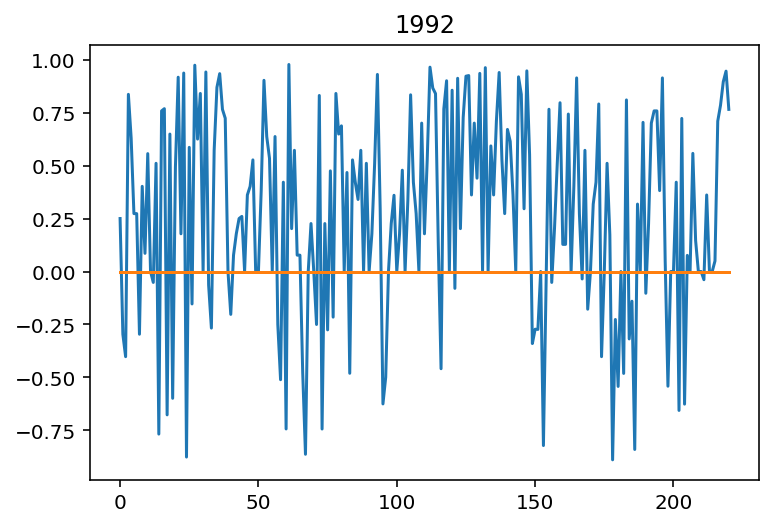

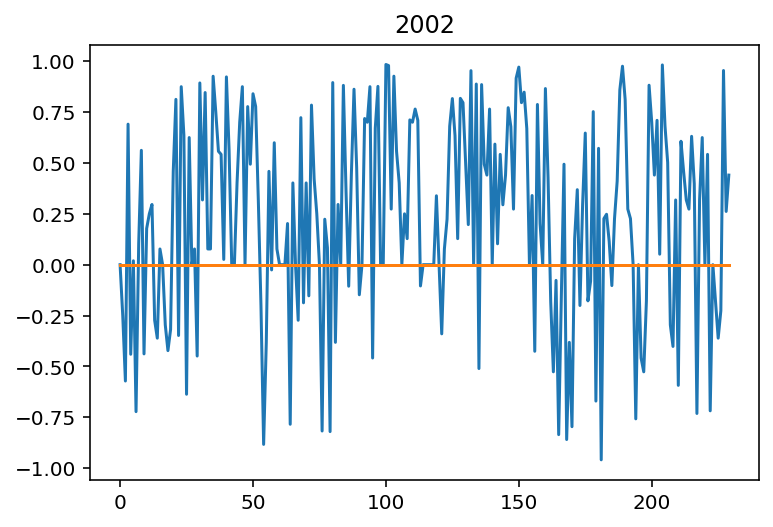

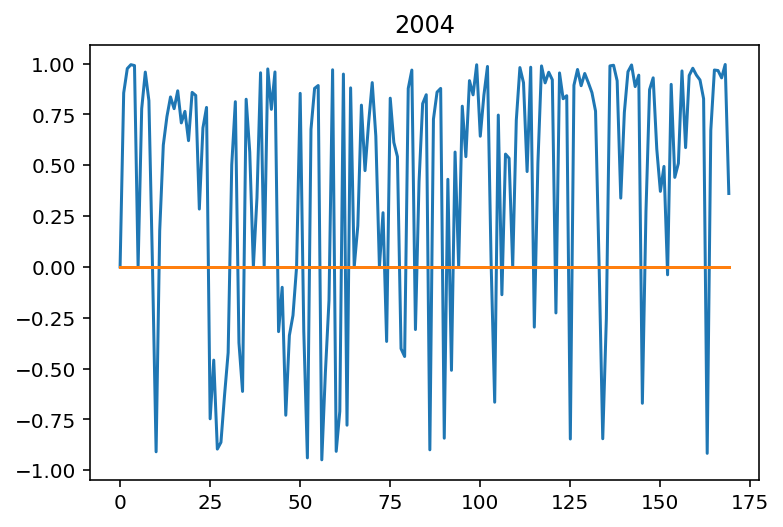

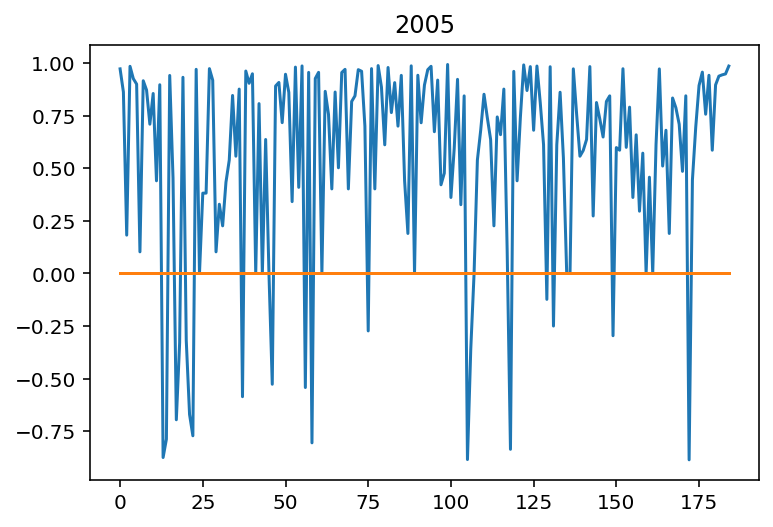

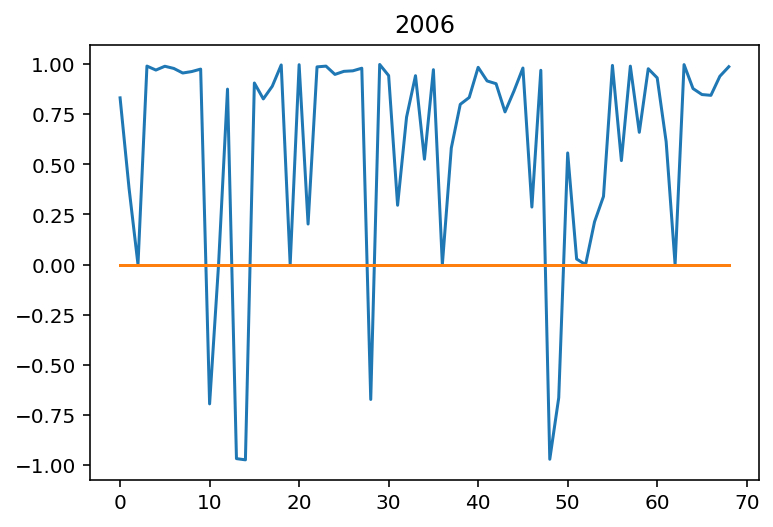

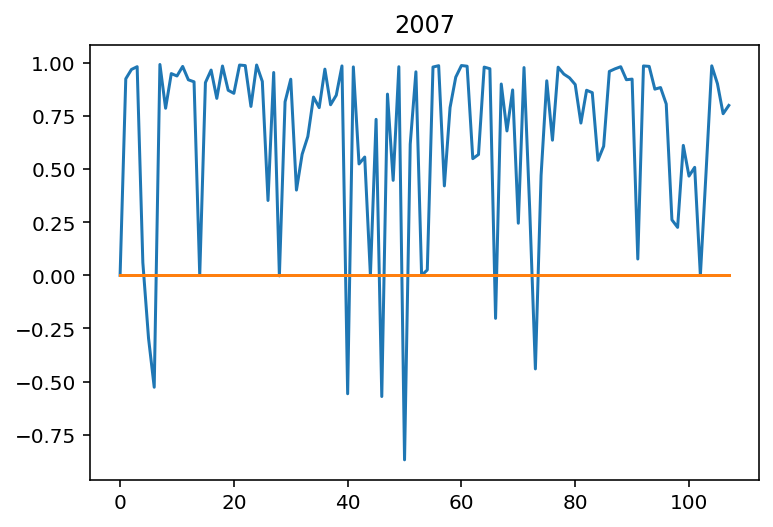

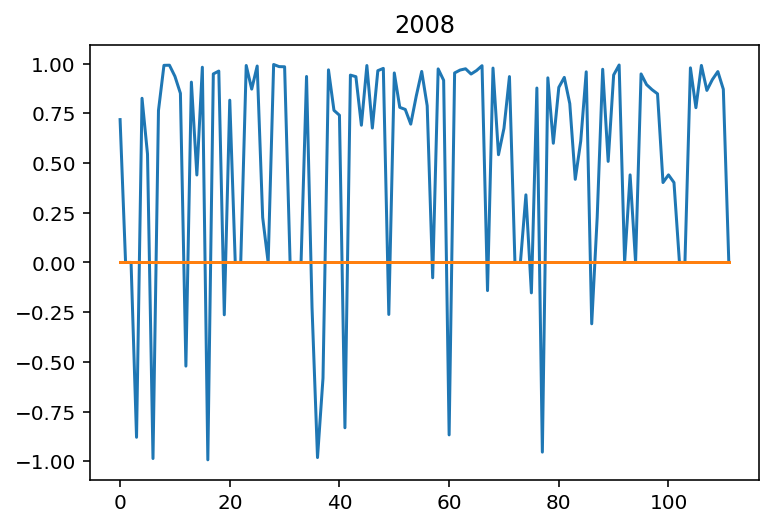

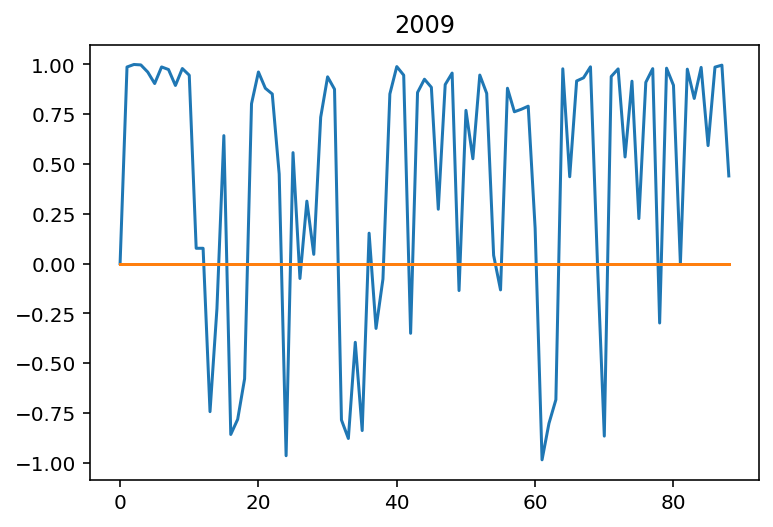

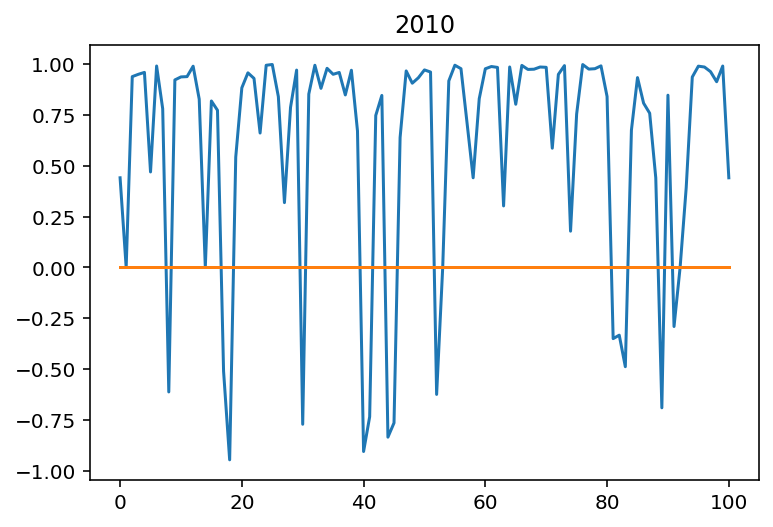

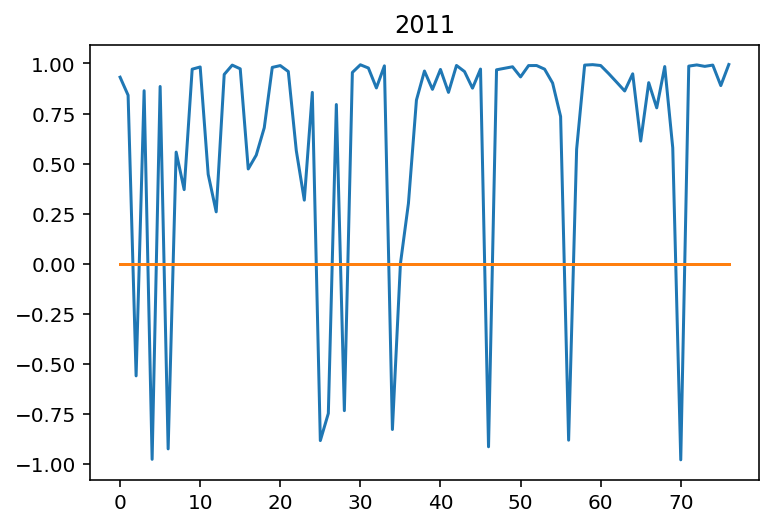

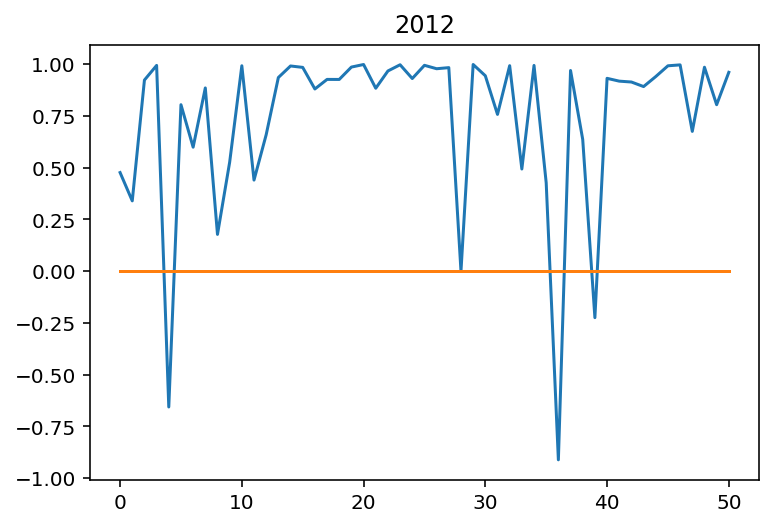

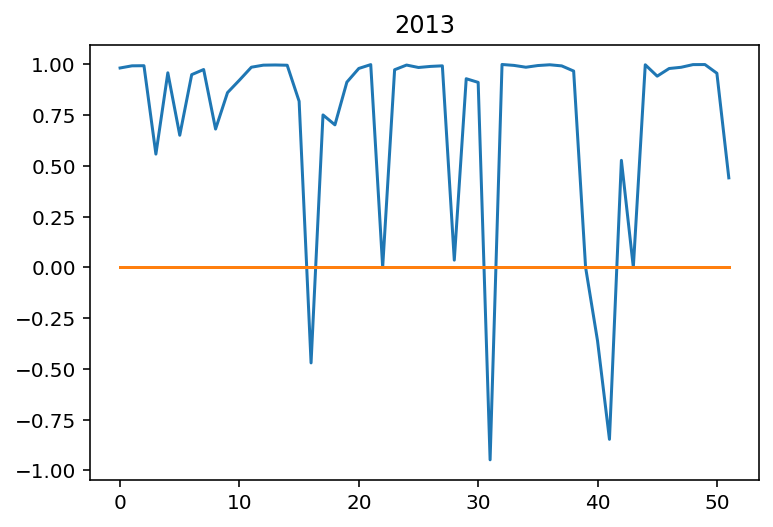

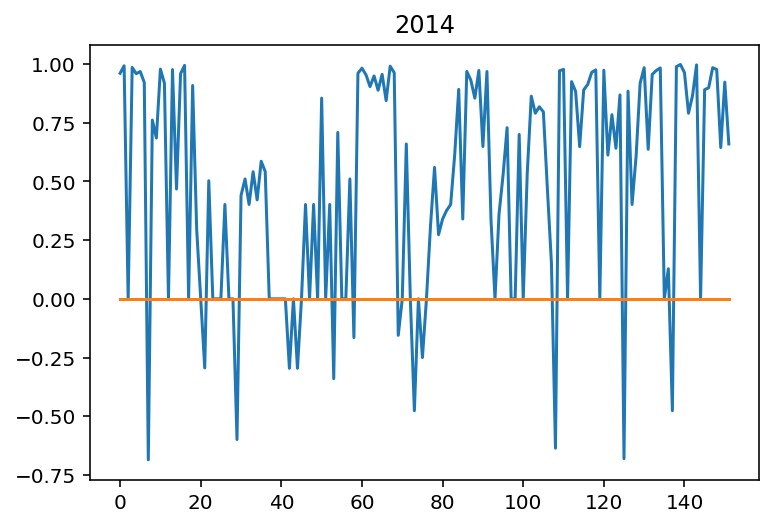

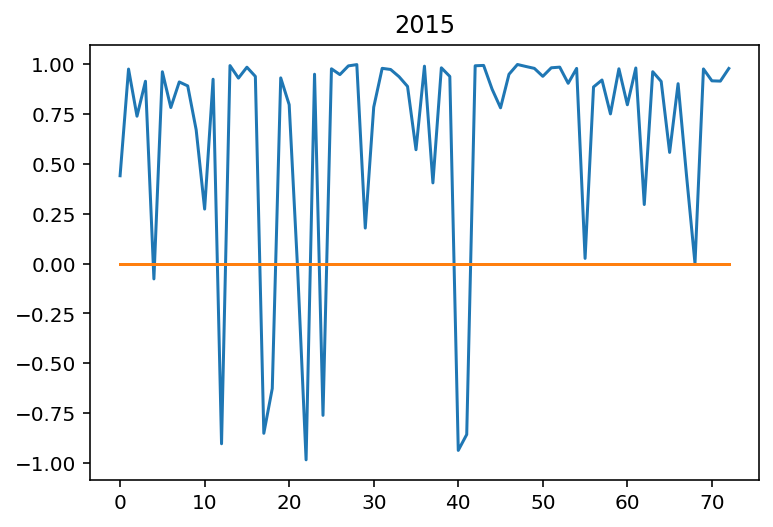

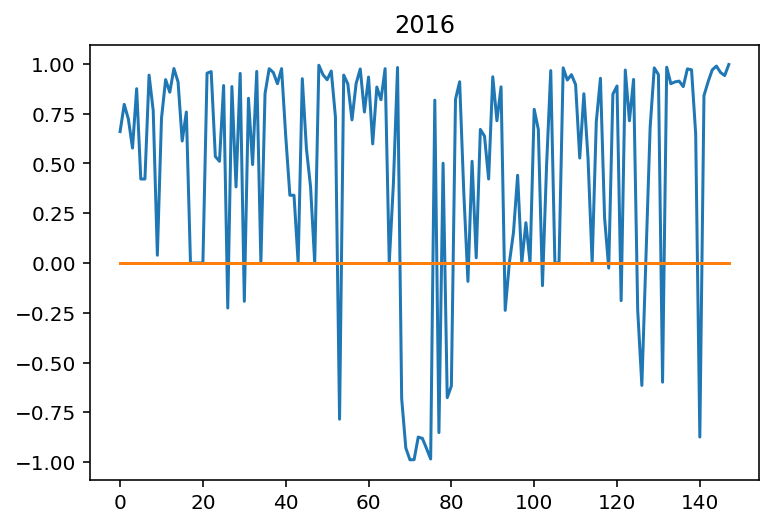

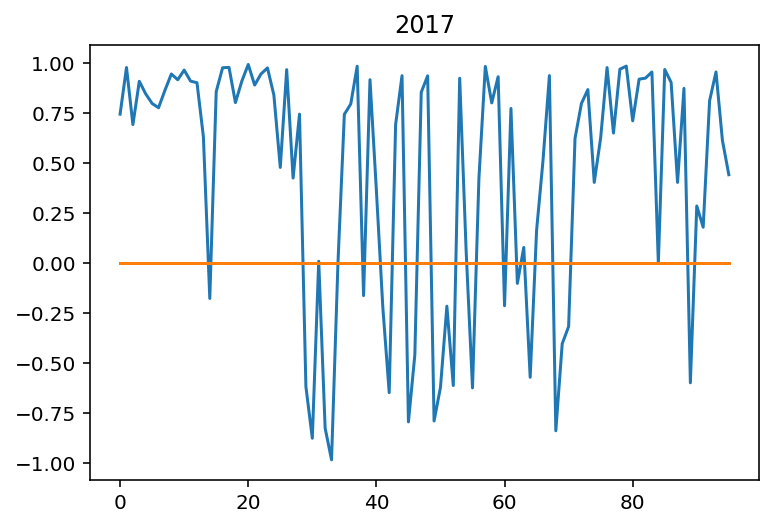

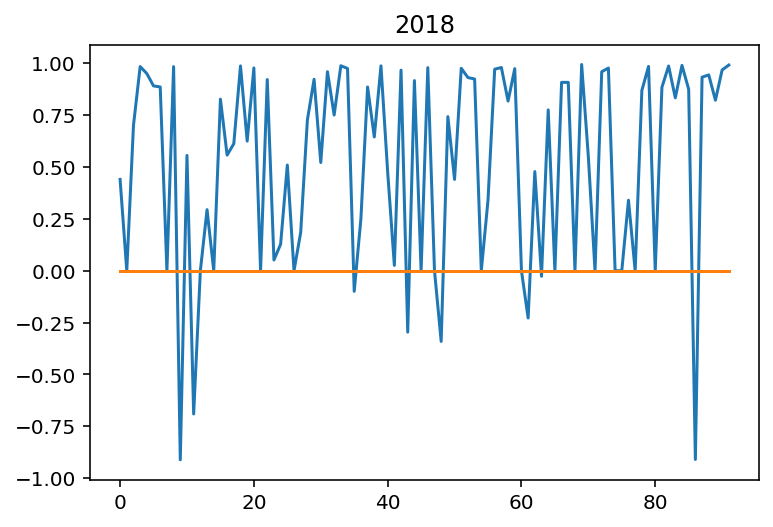

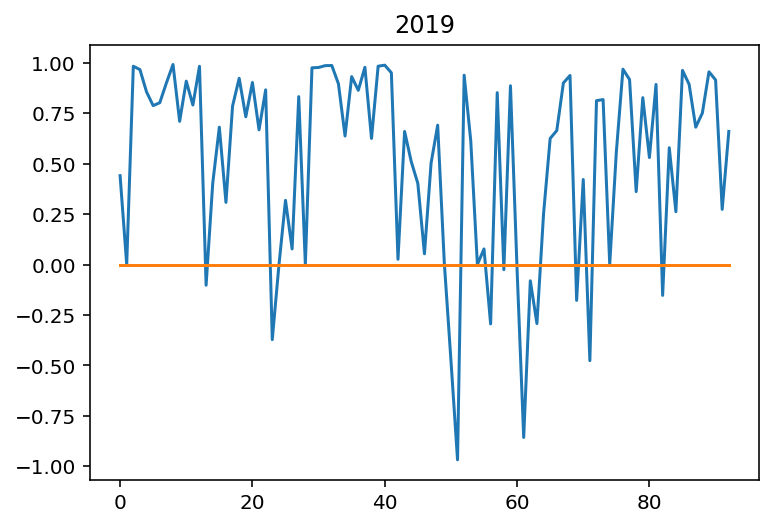

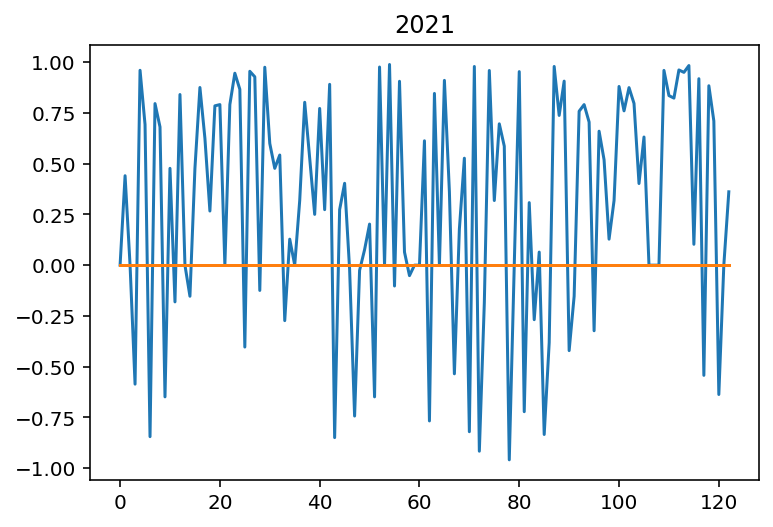

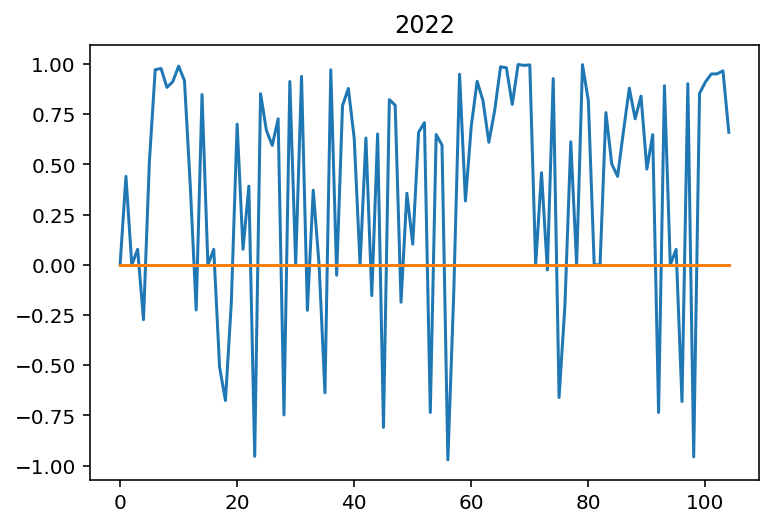

In [13]:
j = 0
for i in fids:
    plt.plot(df[df['Year'] == i].ParasNo,df[df['Year'] == i]["VADER_Score"])
    plt.plot(np.arange(0,len(df[df['Year'] == i])), np.zeros(len(df[df['Year'] == i]))) # add a neutral line
    plt.title(i[0:4])
    
    plt.show()